# Guía 8: Grid Sampling

Para parámetros $\theta$ contínuos, podemos aproximar la distribución posterior contínua considerando una grilla de valores posibles de los parámetros.

**Receta**:
1. Definir la grilla para $\theta$ (cuántos puntos, con qué intervalo - más puntos es más precisión)
2. Calcular el valor del prior para cada valor de $\theta$ en la grilla
3. Calcular la likelihood para cada valor de $\theta$ de la grilla
4. Calcular la posterior (sin normalizar) para cada valor de $\theta$ multiplicando el prior en ese $\theta$ por la likelihood 
5. Normalizar la distribución dividiendo cada valor de la posterior por la suma (ojo con la integral en el caso contínuo) de todos los valores de la posterior.
6. Tomar muestras de $\theta$ a partir de la posterior


**Pros**: 
* Técnica super simple. Es armar una grilla de valores posibles para $\theta$, y para cada uno calcular prior, likelihood, multiplicar y normalizar.
* No hay que calcular integrales. Trabajar con sampleos transforma un problema de cálculo en un problema de *data summary*. En vez de resolver integrales complicadas, una vez que ya tenes muestras de la distribución, calcular probabilidades es simplemente una cuestión de contar valores en un intervalo.
* Por todo esto es más fácil e intuitivo trabajar con muestras de la posterior, que directamente con probabilididades e integrales.

**Contras**: 
* No es práctica en la vida real ya que escala muy mal con el número de parámetros (complejidad del modelo). Para un solo parámetro no hay problema con grillas de 1000 o 10000 valores, pero para dos parámetros con $1000$ valores cada uno ya aparecen $1.000.000$ valores para calcular (con 10 parámetros ya te vas a $10^{30}$ puntos) 




In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import arviz as az
from scipy.special import comb 

In [3]:
#clase

#data sintetica
trials = 10
sucess = stats.binom.rvs(p=.3, n=trials)

def uniform_prior(theta):
    if not  0 <= theta <= 1:
        raise ValueError
    return 1

In [4]:
def binomial_likelihood(theta, y, n):
    return comb(n,y) * theta ** y * (1 - theta) ** (n-y)

In [5]:
posterior_04 = uniform_prior(0.4) * binomial_likelihood(0.4,  sucess , trials)
print(posterior_04)

0.2006581248


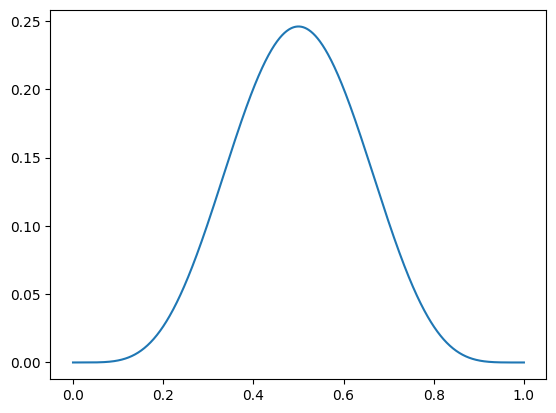

In [6]:
theta_grid = np.linspace(0, 1, 1000)
c_post = []

for theta in theta_grid:
    c_post_i = uniform_prior(theta) * binomial_likelihood(theta,  sucess , trials)
    c_post.append(c_post_i)

fig,ax = plt.subplots()
ax.plot(theta_grid, c_post)

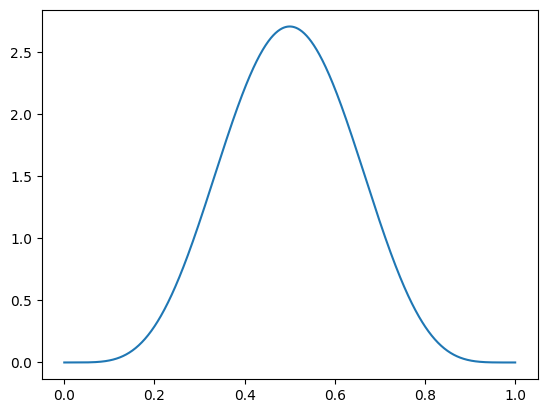

In [7]:
#veo cuanto integra
c_post = np.array(c_post)
post = c_post / (np.sum(c_post) * np.diff(theta_grid)[0])
fig,ax = plt.subplots()
ax.plot(theta_grid, post)

In [8]:
def posterior_binomial(theta_grid, sucesses, trials, prior):
    c_posterior = []
    for theta in theta_grid:
        c_post_i = prior(theta) * binomial_likelihood(theta, sucesses, trials)
        c_posterior.append(c_post_i)
    posterior = c_posterior / (np.sum(c_post) * np.diff(theta_grid)[0])
    return np.array(posterior)

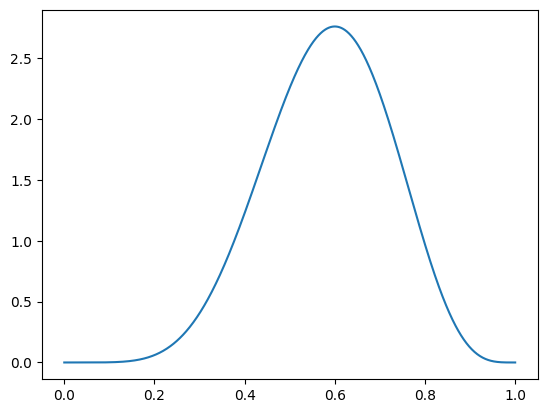

In [9]:
fig,ax = plt.subplots()
posterior = posterior_binomial(theta_grid, 6, 10 ,uniform_prior)
ax.plot(theta_grid, posterior)

(0.0, 1.0)

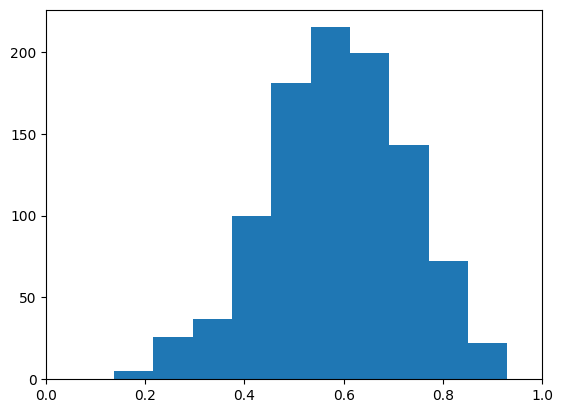

In [10]:
samples = np.random.choice(theta_grid, p=posterior / sum(posterior), size = 1000)
fig,ax = plt.subplots()
ax.hist(samples)
ax.set_xlim(0,1)


In [11]:
print(np.mean(samples))
print(np.median(samples))

0.5871281281281281
0.592092092092092


me dio paja copiar 


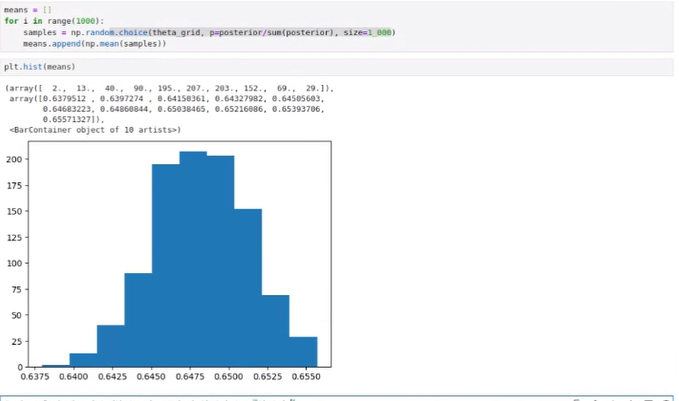

In [12]:
#probabilidad de la siguiente sea cara
samples = np.random.choice(theta_grid, p = posterior / sum(posterior), size = 100000)
number_of_heads = np.sum(np.random.random(size=len(samples)) < samples)

prob = number_of_heads / len(samples)
print(prob)


0.58346


### Posterior predictiva

#### Mal hecha: elijo un estimador puntual de $\theta$ (la media por ejemplo) y sampleo valores de $\tilde{y}$ a partir de ahí

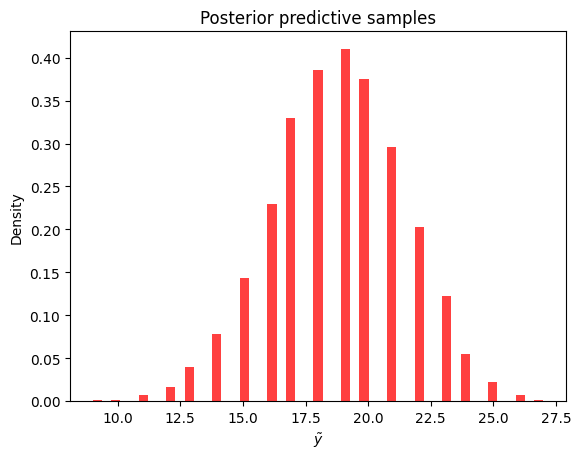

In [20]:
samples_pred_mal = stats.binom.rvs(n=30, p=mean, size=10000)

plt.hist(samples_pred_mal, bins='auto', density=True, alpha=0.75, color='red')
plt.xlabel(r'$\tilde{y}$')
plt.ylabel('Density')
plt.title('Posterior predictive samples')
plt.show()

**¿Por qué está mal?**

Recordemos que para hacer predicciones de observaciones hipotéticas $\tilde{y}$, aparecen dos tipos de incerteza:
* Incerteza en las observaciones para un dado $\theta$. Viene de la naturaleza aleatoria de la variable a observar, cuya distribución depende de $\theta$.
* Incerteza acerca de $\theta$. La cual se manifiesta en su distribución posterior $p(\theta|y)$.



En la figura se ve que el histograma computado usando un único valor de $\theta$ produce una distribución demasiado confiada de las predicciones, es decir, con poca varianza y más angosta que la posterior predictiva verdadera. Esto lleva a que creamos que el modelo es más consistente con los datos de lo que realmente es, por haber tirado a la basura la incerteza sobre $\theta$.


#### ¿Es una distribución binomial?
Si preguntamos es obvio que no, pero ¿por qué no?

No es una distribución binomial ya que integra por sobre todos los $\theta$ posibles de acuerdo a la posterior. Matemáticamente:

$$p(\tilde{y}|y) = \int_0^1 p(\tilde{y}|y,\theta)p(\theta|y)d\theta $$
$$p(\tilde{y}|y) = \int_0^1 p(\tilde{y}|\theta)p(\theta|y)d\theta $$

por ser los dos experimentos independientes dado $\theta$

$$p(\tilde{y}|y) = \int_0^1 Bi(\tilde{y}|\theta,n)Beta(y+1,n-y+1)d\theta $$
y esta expresión define una distribución beta-binomial